# O1v5-SONATA model building
This is an auxiliary notebook for configuring model building, which...
 - extracts required data
 - creates data-based models
 - visualizes data vs. model

...for different types of models, such as:
 - 1st..5th-order connection probability models
 - distance-dependent delay model
 - connection/synapse properties model

<u>Requirements</u>: [connectome-manipulator](https://bbpgitlab.epfl.ch/conn/structural/connectome_manipulator) package (v0.0.5.dev1 or later)

ℹ️ Related ticket: [[ACCS-49](https://bbpteam.epfl.ch/project/issues/browse/ACCS-49)] "Rewiring V5 connectome based on five simplified models of connectivity"

IMPORTANT: For running actual model building on BB5, use <code>sbatch run_model_building.sh model_config__[...].json</code>


In [1]:
# Initialization

""" Global imports """
import json
import os

""" Local imports """
from connectome_manipulator.model_building import model_building

In [2]:
def default_model_config(output_path, circuit_name, circuit_config, seed=7531):
    """Generates a default model config dict w/o any specific model."""

    model_config = {}
    model_config['working_dir'] = os.path.join(output_path, circuit_name)
    model_config['out_dir'] = model_config['working_dir']
    model_config['seed'] = seed
    model_config['circuit_config'] = circuit_config

    return model_config

def export_model_config(model_config, config_path):
    """Writes model config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    fn = f'model_config__{model_config["model"]["name"]}.json'
    for cpath in config_path:
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(model_config, f, indent=2)
        print(f"Config file {fn} written to {cpath}")
    # print(json.dumps(model_config, indent=2))

In [3]:
# Model building configuration
circuit_path = '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/circuits/O1v5-SONATA'
circuit_name = os.path.split(circuit_path)[-1]
circuit_config = os.path.join(circuit_path, 'sonata', 'circuit_config.json') # SONATA config (.json)
output_path = '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/model_building'
config_paths = ['../configs', '/gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs']  # Write to local and proj9 folder

In [24]:
# Check circuit
from bluepysnap import Circuit
c = Circuit(circuit_config)
nodes = c.nodes["default"]
edges = c.edges["default"]
print(f"Total number of neurons: {nodes.size}")
print(f"Total number of synapses: {edges.size}")
nodes.get().head()

Total number of neurons: 219422
Total number of synapses: 356915309


,etype,hypercolumn,layer,me_combo,minicolumn,model_template,morph_class,morphology,mtype,orientation_w,orientation_x,orientation_y,orientation_z,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
0,cNAC,0,1,cNAC187_L1_DLAC_1_sm080904a3_-_Scale_x1.000_y1...,67,hoc:cNAC187,INT,sm080904a3_-_Scale_x1.000_y1.050_z1.000,L1_DLAC,0.884299,0.0,-0.466922,0.0,INH,357.926033,2010.226841,286.579939,-0.024048,0.051531
1,cNAC,0,1,cNAC187_L1_HAC_1_sm080908a4,190,hoc:cNAC187,INT,sm080908a4,L1_HAC,0.011933,0.0,0.999929,0.0,INH,481.576150,1939.091098,281.655613,-0.019043,0.035313
2,cNAC,0,1,cNAC187_L1_DLAC_1_sm080930a2_-_Scale_x1.000_y1...,194,hoc:cNAC187,INT,sm080930a2_-_Scale_x1.000_y1.050_z1.000_-_Clone_0,L1_DLAC,0.801429,0.0,-0.598090,0.0,INH,273.809119,1991.641035,382.820379,-0.030396,0.054475
3,cNAC,0,1,cNAC187_L1_DAC_1_sm080902a3-2_-_Scale_x1.000_y...,262,hoc:cNAC187,INT,sm080902a3-2_-_Scale_x1.000_y0.950_z1.000,L1_DAC,0.959961,0.0,-0.280135,0.0,INH,374.685900,2031.048689,399.490194,-0.045410,0.087197
4,cNAC,0,1,cNAC187_L1_HAC_1_sm080908a4,282,hoc:cNAC187,INT,sm080908a4,L1_HAC,-0.176302,0.0,0.984336,0.0,INH,524.906386,1917.380292,274.869587,-0.019043,0.035313


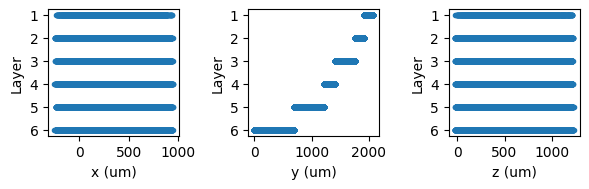

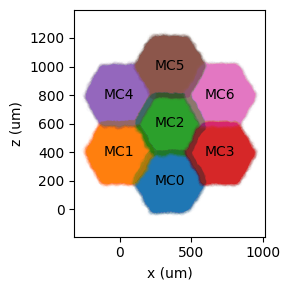

In [6]:
# Check axis alignment
import matplotlib.pyplot as plt
import numpy as np
lay = nodes.get(properties="layer")
pos = nodes.get(properties=["x", "y", "z"])

plt.figure(figsize=(8, 2))
for pidx, p in enumerate(pos.columns):
    plt.subplot(1, len(pos.columns) + 1, pidx + 1)
    plt.plot(pos[p], lay, '.')
    plt.xlabel(f"{p} (um)")
    plt.ylabel("Layer")
    plt.gca().invert_yaxis()
    plt.yticks(np.unique(lay))
plt.tight_layout()
plt.show()

mcs = nodes.get(properties="hypercolumn")
plt.figure(figsize=(3, 3))
for mc in np.unique(mcs):
    plt.plot(pos[mcs==mc]["x"], pos[mcs==mc]["z"], ".", label=f"MC{mc}", alpha=0.01)
    plt.text(np.mean(pos[mcs==mc]["x"]), np.mean(pos[mcs==mc]["z"]), f"MC{mc}", ha="center", va="center")
    plt.xlabel("x (um)")
    plt.ylabel("z (um)")
    plt.axis("equal")
plt.tight_layout()
plt.show()

In [23]:
# Check edges table (MC2 column)
mc2_nodeset = "mc2_Column"
edges_table = edges.afferent_edges(mc2_nodeset, properties=sorted(edges.property_names))
conns, syn_conn_idx, num_syn_per_conn = np.unique(edges_table[['@source_node', '@target_node']], axis=0, return_inverse=True, return_counts=True)
print(f"Number of neurons in MC2 column: {len(nodes.ids(mc2_nodeset))}")
print(f"Number of synapses in MC2 column: {edges_table.shape[0]}")
print(f"Number of connections in MC2 column: {len(conns)}")
edges_table.head()

Number of neurons in MC2 column: 31346
Number of synapses in MC2 column: 60992747
Number of connections in MC2 column: 14132808


,@source_node,@target_node,absolute_efficacy,afferent_section_id,afferent_section_type,afferent_segment_id,afferent_segment_offset,conductance,decay_time,delay,...,efferent_section_id,efferent_segment_id,efferent_segment_offset,facilitation_time,morpho_branch_order_axon,morpho_branch_order_dend,n_rrp_vesicles,nrn_line,syn_type_id,u_syn
97301463,776,62692,0,0,0,0,-1.0,0.792460,8.153839,2.047022,...,61,27,0.869010,20.0,14,1,1,0,1,0.241363
97301464,776,62692,0,0,0,0,-1.0,0.921636,8.670543,2.060920,...,62,1,1.290452,23.0,15,1,1,1,1,0.271896
97301465,776,62692,0,0,0,0,-1.0,0.634884,7.523536,2.078442,...,62,5,0.197187,18.0,15,1,1,2,1,0.204118
97301466,776,62692,0,0,0,0,-1.0,0.688324,7.737294,2.095757,...,62,8,0.166512,19.0,15,1,1,3,1,0.216749
97301467,776,62692,0,0,0,0,-1.0,1.151881,9.591522,2.056906,...,73,1,0.754436,26.0,15,1,1,4,1,0.326317


## Create model building configs
- Whole O1v5 connectome
- EXC-EXC connections only

### Linear distance-dependent delay model

In [96]:
# Linear distance-dependent delay model
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'DistDepDelayO1v5EE',
                         'fct': {'source': 'delay',
                                 'kwargs': {'sel_src': {'synapse_class': 'EXC'},
                                            'sel_dest': {'synapse_class': 'EXC'},
                                            'sample_size': None,
                                            'bin_size_um': 50,
                                            'max_range_um': None}}}
export_model_config(model_config, config_paths)

Config file model_config__DistDepDelayO1v5EE.json written to ../configs
Config file model_config__DistDepDelayO1v5EE.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


In [108]:
# BluepySnapError: No such property: afferent_center_x/y/z

### Connection/synapse properties model

In [110]:
# Connection/synapse properties model
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnPropsPerPathwayO1v5EE',
                         'fct': {'source': 'conn_props',
                                 'kwargs': {'sel_src': {'synapse_class': 'EXC'},
                                            'sel_dest': {'synapse_class': 'EXC'},
                                            'min_sample_size_per_group': 10,
                                            'max_sample_size_per_group': 1000,
                                            'distr_types': {'absolute_efficacy': 'constant',
                                                            'conductance': 'gamma',
                                                            'decay_time': 'truncnorm',
                                                            'depression_time': 'truncnorm',
                                                            'facilitation_time': 'truncnorm',
                                                            'n_rrp_vesicles': 'gamma',
                                                            'n_syn_per_conn': 'gamma',
                                                            'syn_type_id': 'constant',
                                                            'u_syn': 'truncnorm'},
                                            'data_types': {'absolute_efficacy': 'int',
                                                           'n_rrp_vesicles': 'int',
                                                           'n_syn_per_conn': 'int',
                                                           'syn_type_id': 'int'},
                                            'data_bounds': {'n_rrp_vesicles': [1, 1000],
                                                            'n_syn_per_conn': [1, 1000]}}}}
export_model_config(model_config, config_paths)

Config file model_config__ConnPropsPerPathwayO1v5EE.json written to ../configs
Config file model_config__ConnPropsPerPathwayO1v5EE.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


### Connection probability models

In [54]:
# Connection probability model: 1st-order model (uniform)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb1stOrderO1v5EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': 1,
                                            'sel_src': {'synapse_class': 'EXC'},
                                            'sel_dest': {'synapse_class': 'EXC'},
                                            'sample_size': 100000}}}
export_model_config(model_config, config_paths)

Config file model_config__ConnProb1stOrderO1v5EE.json written to ../configs
Config file model_config__ConnProb1stOrderO1v5EE.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


In [154]:
# Connection probability model: 2nd-order model (distance-dependent)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb2ndOrderO1v5EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': 2,
                                            'sel_src': {'synapse_class': 'EXC'},
                                            'sel_dest': {'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'bin_size_um': 50,
                                            'max_range_um': None,
                                            'sample_size': 100000}}}
export_model_config(model_config, config_paths)

Config file model_config__ConnProb2ndOrderO1v5EE.json written to ../configs
Config file model_config__ConnProb2ndOrderO1v5EE.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


In [156]:
# Connection probability model: 3rd-order model (bipolar distance-dependent)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb3rdOrderO1v5EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': 3,
                                            'bip_coord': 1,  # y coordinate [TO BE IMPLEMENTED]
                                            'sel_src': {'synapse_class': 'EXC'},
                                            'sel_dest': {'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'bin_size_um': 50,
                                            'max_range_um': None,
                                            'sample_size': 100000}}}
export_model_config(model_config, config_paths)

Config file model_config__ConnProb3rdOrderO1v5EE.json written to ../configs
Config file model_config__ConnProb3rdOrderO1v5EE.json written to /gpfs/bbp.cscs.ch/project/proj9/bisimplices/pokorny/simplified_connectome_models/configs


In [ ]:
# Connection probability model: 4th-order (reduced) model (offset-dependent)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb4thOrderO1v5EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': '4R',
                                            'axial_coord': 1,  # y coordinate, i.e. radial coord within x/z plane [TO BE IMPLEMENTED]
                                            'sel_src': {'synapse_class': 'EXC'},
                                            'sel_dest': {'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'bin_size_um': 50,
                                            'max_range_um': [400, [-1500, 600]],
                                            'smoothing_sigma_um': None,
                                            'plot_model_ovsampl': 7,
                                            'plot_model_extsn': 0,
                                            'model_specs': {'name': 'LinearInterpolation'},
                                            'sample_size': 1000}}}  # 100000  # [TESTING]
export_model_config(model_config, config_paths)

In [ ]:
# Connection probability model: 5th-order (reduced) model (position- & offset-dependent)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb5thOrderO1v5EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': '5R',
                                            'axial_coord': 1,  # y coordinate, i.e. radial coord within x/z plane [TO BE IMPLEMENTED]
                                            'sel_src': {'synapse_class': 'EXC'},
                                            'sel_dest': {'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'position_bin_size_um': 400,
                                            'position_max_range_um': [-2800, 400], 
                                            'offset_bin_size_um': 100,
                                            'offset_max_range_um': [400, [-1500, 600]],
                                            'smoothing_sigma_um': None,
                                            'plot_model_ovsampl': 7,
                                            'plot_model_extsn': 0,
                                            'model_specs': {'name': 'LinearInterpolation'},
                                            'sample_size': 1000}}}  # 50000  # [TESTING]
export_model_config(model_config, config_paths)

## Run model building

In [ ]:
# Model building - Run from notebook
# model_building.main(model_config, show_fig=True, force_recomp=[True, True])

# Model building - Run using sbatch
# COMMAND: sbatch run_model_building.sh <model_config>.json 1 1